# RETAIL STOCK PREDICTION
## Purpose of the project
The purpose of this project is to predict the amount of a product that will be on demand in the future in a particular country at a particular prices. 

## Implications
This predictive model will provide clues manage the stores inventory more efficiently. 

## Data origin and description
The data was obtained from the UCI Machine Learning Repository, and can be accessed here in this github or in teh original site (https://archive.ics.uci.edu/ml/machine-learning-databases/00352/). 

The original description of the data indicates that the file contains purchase transactions from 01/12/2010 to 09/12/2011 from a UK based store that seems gifts. The customers (mostly wholesalers) are locted in the UK as well as in other countries in other parts of the world as it the store is an online retailor. 

The file contains the following columns (as per the original site):
- InvoiceNo: Invoice number. Categorical. A unique 6-digit number assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- StockCode: Product or item code. Categorical. A unique 5-digit number assigned to each distinct product. 
- Description: Product name. Text. 
- Quantity: The quantities of each product per transaction. Numeric.	
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated. 
- UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
- CustomerID: Customer number. Categorical. A unique 5-digit number assigned to each customer. 
- Country: Country name. Categorical, the name of the country where each customer resides.


### Data Exploration
Here the code reads the data the excel file, performs exploratory statistics, and plot plot figures with some of the variables.  

In [216]:
# Importing the necesaty libraries:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [2]:
xlfile = 'Online Retail.xlsx'
retail = pd.ExcelFile(xlfile)


In [107]:
df_retail = retail.parse("Online Retail")
display(df_retail.head())
display(df_retail.describe())
print(df_retail.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


(541909, 8)


The first step is to remove the rows that correspond to order cancellations. While this might also be useful in the prediction, there is no way to tell if the customer needed or not the product. From now on, the assumption will be that it did not needed. 

There are some orders, three of them, that start with an 'A'. Their description says 'adjust bad debt'. I remove those too. 

Some values in the Invoice column are numeric therefore I transform them to string for the script to be able to remove the rows with letters. 

Data with positive UnitPrice are maintained. 

In [108]:
df_retail.CustomerID = df_retail.CustomerID.astype(str)
df_retail.InvoiceNo = df_retail.InvoiceNo.astype(str)
df_retail = df_retail[df_retail.InvoiceNo.str.contains('A|C', na=False)==False]
df_retail.shape

(532618, 8)

In [169]:
df_retail=df_retail[df_retail.UnitPrice>0]
df_retail=df_retail[df_retail.StockCode!='POST']
df_retail=df_retail[df_retail.StockCode!='M']
df_retail=df_retail[df_retail.StockCode!='PADS']
df_retail=df_retail[df_retail.StockCode!='S']
df_retail=df_retail[df_retail.StockCode!='AMAZONFEE']
df_retail=df_retail[df_retail.StockCode!='BANK CHARGES']
df_retail=df_retail[df_retail.StockCode!='m']
df_retail.shape

(528188, 8)

Checking the countries in the list. Noticed the 'unspecified' category. This will be remove in the next cell

In [170]:
display(pd.DataFrame(df_retail.Country.unique(), columns=['Country']).sort_values(by='Country').reset_index(drop=True))
df_retail = df_retail[df_retail.Country.str.contains('Unspecified', na=False)==False]
df_retail.shape

,Country
0,Australia
1,Austria
2,Bahrain
3,Belgium
4,Brazil
5,Canada
6,Channel Islands
7,Cyprus
8,Czech Republic
9,Denmark


(528188, 8)

In [171]:
df_retail.describe()

,Quantity,UnitPrice
count,528188.000000,528188.000000
mean,10.260496,3.665529
std,37.718894,17.322127
min,1.000000,0.040000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,11.000000,4.130000
max,4800.000000,4505.170000


### Visualization
Now We start with the visualization. Fist, look at the relation between the numeric variables, Unit Price and Quantity.

From the graph below, it seems there are a few outliers in both categories. Quantities higher than 70000 and prices higher than 8000. 

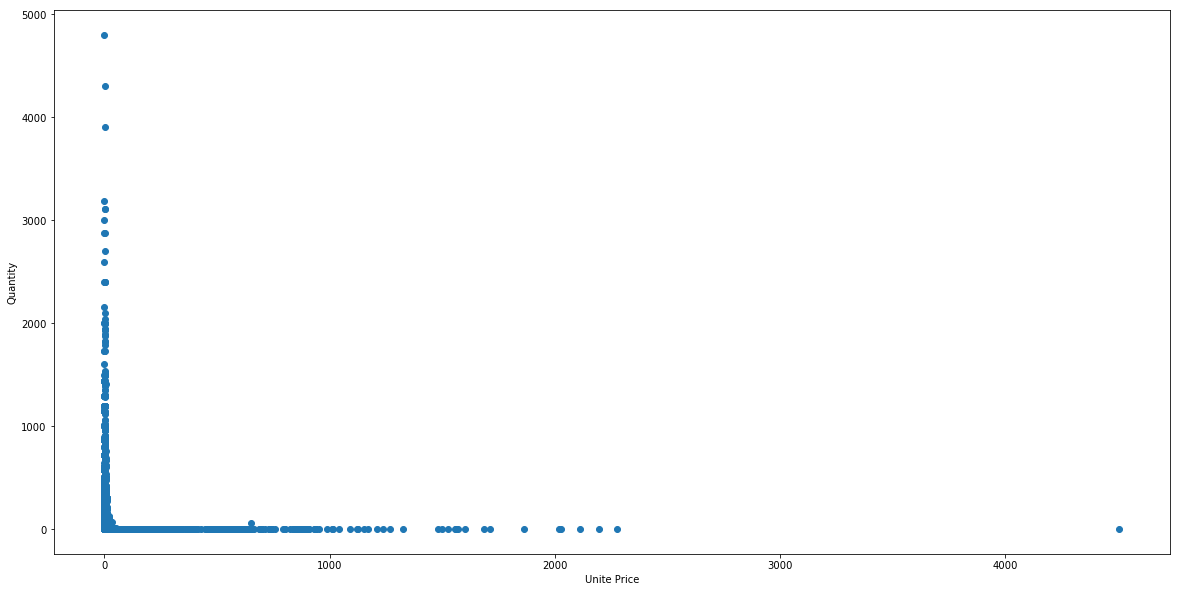

In [233]:
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(df_retail.UnitPrice, df_retail.Quantity)
plt.xlabel("Unite Price")
plt.ylabel("Quantity")
plt.savefig('UnitPrice_to_Quantity.jpg')

There appears to be no correlation with these two features, atleast not linear one.

Now, I am exploring the relation between the product and the countries. 

In [220]:
df_country_prod = df_retail.groupby(['Country'])['StockCode'].count()
df_country_prod = df_country_prod.reset_index(drop=False)
df_country_prod
df_country_prod.sort_values(by='StockCode')

,Country,StockCode
29,Saudi Arabia,9
2,Bahrain,18
8,Czech Republic,24
4,Brazil,32
22,Lithuania,35
21,Lebanon,45
28,RSA,57
11,European Community,57
35,United Arab Emirates,67
23,Malta,109


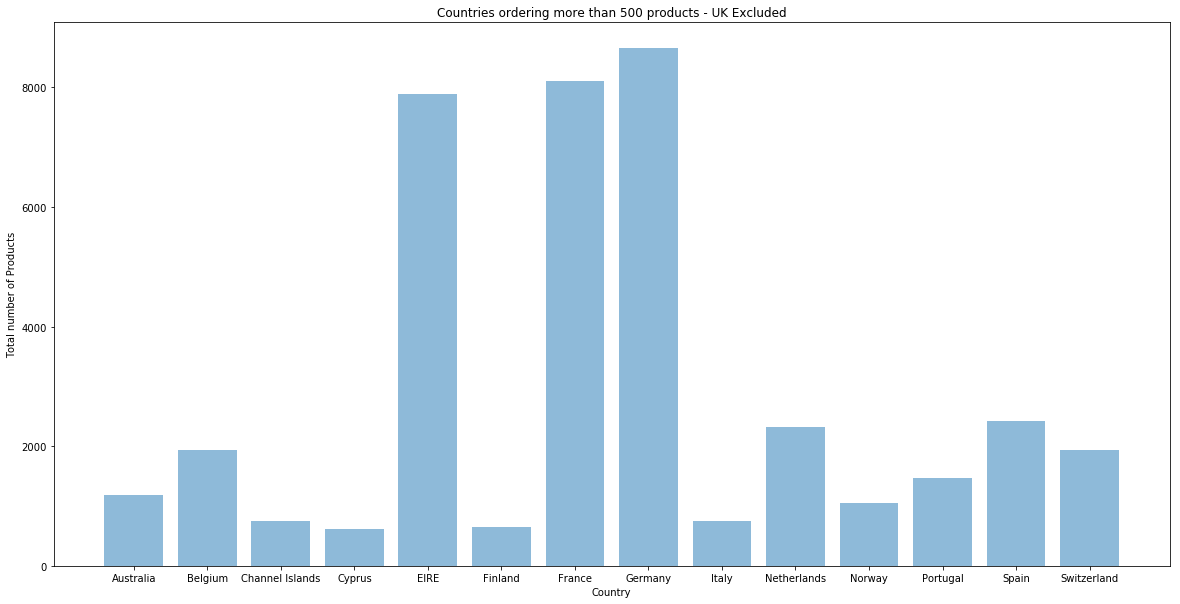

In [231]:
df_country_prod1=df_country_prod[(df_country_prod.StockCode>500) & (df_country_prod.StockCode<10000)]
df_country_prod1.sort_values(by='StockCode')

objects = df_country_prod1.Country
y_pos = np.arange(len(objects))
performance = (df_country_prod1.StockCode)
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Country')
plt.ylabel('Total number of Products')
plt.title('Countries ordering more than 500 products - UK Excluded')
 
plt.savefig('Countries_order_amt.jpg')